In [1]:
# %matplotlib widget
# %matplotlib inline
%matplotlib qt5

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
mpl.rcParams['figure.dpi'] = 150

import matplotlib.style as style
style.use('S:\Connie\prx.mplstyle')

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = ['o', '*', 's', '^']

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [3]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

### Set save data

In [4]:
save_data = False

In [5]:
def prev_data(expt_path, filename=None):
    """Reopen saved data"""
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [6]:
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
data_path = 'S:\\QRAM\\qram_4QR2\\'
expt_path = os.path.join(data_path, 'data', 'data_241025')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_241025


In [7]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
# config_path = os.path.join('S:\Seb\experiements\qram_tprocv1_expts\configs', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Load config

In [8]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [9]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
# im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
im = InstrumentManager(ns_address='10.108.30.75') # Spilker Vibranium

print(list(im))
# print(im)

['Pyro.NameServer', 'Qick_QRAM']


In [10]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# soc = QickConfig(im['Qick187'].get_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Sat Oct  5 10:21:47 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 32768 samples (4.762 us)
		fs=6881.280 MHz, fabric=430.080 MH

### Defining resonator frequency

In [268]:
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

freqs = np.array(yaml_cfg.device.readout.frequency)
mixer = np.array(yaml_cfg.hw.soc.dacs.readout.mixer_freq)
res_freq = freqs + mixer
print('Resonator frequencies:', res_freq)

Resonator frequencies: [6810.025      5795.76166666 7702.36823333 6971.1       ]


In [203]:
full_mux_chs = [5, 4, 5, 5]
# full_mux_chs = [4]*4
mixer_freqs = [6500, res_freq[1], 6500, 6500]
# mixer_freqs = [6500, 5700, 6500, 6500]
# mixer_freqs = [6500]*4
mask = [0, 1, 2, 3]

print('mixer freqs', mixer_freqs)
wrapped_freqs = res_freq - mixer_freqs
print('orig unmixed freqs', wrapped_freqs)

fs = 2457.6
print(fs/2)
for i_f, f in enumerate(wrapped_freqs):
    if f > fs/2:
        wrapped_freqs[i_f] = fs - f
print('wrapped freqs', wrapped_freqs.tolist())
print('wrapped freqs with mixer', wrapped_freqs + mixer)

# use_full_gen = False
use_full_gen = True

mixer freqs [6500, 5795.0365011, 6500, 6500]
orig unmixed freqs [ 309.03475717    0.         1201.38662963  470.29536424]
1228.8
wrapped freqs [309.0347571700004, 0.0, 1201.3866296300002, 470.2953642399998]
wrapped freqs with mixer [7509.03475717    0.         8401.38662963 7670.29536424]


# Qubit/resonator to probe

In [13]:
qubit_i = 3

## Set reps and rounds

In [14]:
reps = 100
rounds = 8

# Resonator spectro

In [994]:
qubit_i = 1

In [ ]:
rspec = meas.ResonatorSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

if use_full_gen:
    rspec.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freqs
    for i in range(4):
        rspec.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freqs[i]
        print(f"Qubit {i} frequency: {rspec.cfg.device.readout.frequency[i]}")

span = 1.0 # MHz
npts = 100
# npts = 10
rspec.cfg.expt = dict(
    start= rspec.cfg.device.readout.frequency[qubit_i]-0.5*span, # [MHz]
    step=span/npts,
    expts=npts,
    # reps=reps*rounds,
    reps=1000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
    full_mux_expt=use_full_gen, 
)

# rspec.cfg.device.readout.gain[qubit_i] = 0.3
# rspec.cfg.device.readout.readout_length[qubit_i] = 3

if rspec.cfg.expt.full_mux_expt:
    rspec.cfg.device.readout.readout_length = t[-1]
    rspec.cfg.expt.mask = mask
    rspec.cfg.expt.full_mux_chs = full_mux_chs
    if not use_iq_pulses:
        # rspec.cfg.expt.lengths = [t[-1]]*4
        rspec.cfg.device.readout.readout_length = 3
        rspec.cfg.expt.lengths = [rspec.cfg.device.readout.readout_length]*4    
        rspec.cfg.device.readout.gain = [1e-4]*4
        rspec.cfg.device.readout.gain[qubit_i] = 0.05
    else:
        # rspec.cfg.device.readout.gain = rspec.cfg.device.readout.gain_full_mux
        rspec.cfg.device.readout.gain = [1e-4]*4
        rspec.cfg.expt.pulse_I_shapes = I_values
        rspec.cfg.expt.pulse_Q_shapes = Q_values
        rspec.cfg.expt.times_us = t_us
        rspec.cfg.expt.plot_IQ = False
        rspec.cfg.device.readout.gain[qubit_i] = 0.40/4


print(rspec.cfg.device.readout.gain)
print(rspec.cfg.device.readout.frequency)
print(rspec.cfg.hw.soc.dacs.readout.mixer_freq)

if not rspec.cfg.expt.pulse_e: rspec.cfg.device.readout.relax_delay = 25

try:
    rspec.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

[0.3, 0.06, 0.85, 0.75]
[-389.975, 5795.761666663333, 502.368233333334, -228.9]
[7200, 0, 7200, 7200]


  0%|          | 0/100 [00:00<?, ?it/s]

In [282]:
# TESTING
# # rspec = meas.ResonatorSpectroscopyExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# rspec.data = temp_data

rspec.data = rspec.analyze(fit=True)
# rspec_fit = rspec.data['fit']
# if not isinstance(rspec_fit, (list, np.ndarray)):
#     rspec.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
rspec.display(fit=True)

electrical delay phase correction (no mux support) (deg) 3.7505143851742795
param guess [5795.756666663333, 28978.783333316664, 28978.783333316664, 0, -0.09542441019031167, 0.9526334019149737]
param bounds ([5795.271666663333, 0, 0, -6.283185307179586, -0.1431366152854675, -inf], [5796.241666663333, 1000000000.0, 100000000.0, 6.283185307179586, 0.1431366152854675, 1.0281827550137694])
popt [ 5.79543648e+03  2.30578652e+04  2.61532126e+05  1.35765807e+00
 -2.63091255e-02 -1.91178579e-02]

Freq with minimum transmission: 5795.571666663333
Freq with maximum transmission: 5795.281666663333
From fit:
	f0: 5795.4364800180265
	Qi: 23057.86524591893 	 kappa_i/2pi: 0.25134314986266026
	Qe: 261532.12593266374 	 kappa_e/2pi: 0.022159558636823715
	Q0: 21189.685878481752
	kappa [MHz]: 0.27350270849948394
	phi [radians]: 1.3576580658138766
baseline 2071.505701958924


### Fitting VNA resonator sweeps

In [1204]:
def pow_to_mW(pow_dBm):
    return 10**(pow_dBm/10)*1e-3

def W_to_pow(W):
    return 10*np.log10(1e3*W)

def pow_ratio_to_lin(pow_dB):
    return 10**(pow_dB/10)

In [1731]:
import csv

qubit_i = 1

# Define the file path
csv_file_path = "S:\QRAM\qram_4QR2\data\data_241025\\"
csv_file_name = f"qubit{qubit_i}_resonator_vna.csv"

data = []
with open(csv_file_path+csv_file_name, mode='r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        if row[0][0] == '#':
            continue
        if row[0] == 'Frequency':
            data_names = row
            continue
        data.append(row)
data_array = np.array(data)
data_array = data_array.astype(float)

# print(data_array.shape)
# print(data_names)

freqs_MHz = np.array(data_array)[:,0]*1e-6
s21_dB = np.array(data_array)[:,1]
s21_lin = pow_ratio_to_lin(s21_dB)

baseline = np.mean(np.sort(s21_lin)[-100:])
# fit_xdata = freqs_MHz[100:400]
# fit_ydata = s21_lin[100:400]
fit_xdata = freqs_MHz
fit_ydata = s21_lin
p, pcov = meas.fitting.fithanger(fit_xdata, fit_ydata/baseline)
f0, Qi, Qe, phi, slope, a0 = p
print("From fit:")
print(f"\tf0: {f0}")
print(f"\tQi: {Qi} \t kappa_i/2pi: {f0/Qi}")
print(f"\tQe: {Qe} \t kappa_e/2pi: {f0/Qe}")
print(f"\tQ0: {1/(1/Qi+1/Qe)}")
print(f"\tkappa [MHz]: {f0*(1/Qi+1/Qe)}")
print(f"\tphi [radians]: {phi}")

plt.figure(figsize=(7,4))
plt.title(f"Qubit {qubit_i}")
plt.plot(freqs_MHz, s21_lin)
plt.plot(freqs_MHz, baseline*meas.fitting.hangerS21func_sloped(freqs_MHz, *p))
plt.xlabel('Frequency [MHz]')
plt.ylabel('S21 [linear]')
plt.tight_layout()
plt.show()

param guess [5795.844308, 28979.22154, 28979.22154, 0, -0.7174332609477474, 0.7421258759506688]
param bounds ([5795.644308, 0, 0, -6.283185307179586, -1.076149891421621, -inf], [5796.044308, 1000000000.0, 100000000.0, 6.283185307179586, 1.076149891421621, 1.184634364910713])
popt [5.79582782e+03 9.56265138e+08 3.54634662e+04 4.63304196e-01
 3.77704379e-01 4.65465406e-03]
From fit:
	f0: 5795.827822687153
	Qi: 956265138.3297026 	 kappa_i/2pi: 6.060900466172655e-06
	Qe: 35463.46615694538 	 kappa_e/2pi: 0.16343094600616365
	Q0: 35462.15102922351
	kappa [MHz]: 0.16343700690662982
	phi [radians]: 0.4633041957551409


# Spectro versus power

In [ ]:
span_f = 4 # MHz
npts_f = 100

stop_gain = 0.8
start_gain = 0.05
npts_gain = 8

step_gain = (stop_gain - start_gain)/npts_gain

reps = 300

### Ground state

In [ ]:
rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)


if use_full_gen:
    rpowspec.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freq
    for i in range(4):
        if i == 1: rpowspec.cfg.device.readout.frequency[i] = 800
        else: rpowspec.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freq
        print(f"Qubit {i} frequency: {rpowspec.cfg.device.readout.frequency[i]}")

rpowspec.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.5, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_gain=start_gain, # Gain start value
    step_gain=step_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=reps, # Number averages per point
    pulse_e=False, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
    full_mux_expt = True,
    mask = [0,1,2,3],
    full_mux_ch = 4,
)
# rpowspec.cfg.device.readout.relax_delay = 300 # Wait time between experiments [us]
rpowspec.cfg.device.readout.relax_delay = 30 # Wait time between experiments [us]
rpowspec.cfg.device.readout.readout_length = 3

if use_full_gen:
    rpowspec.cfg.expt.full_mux_expt = True
    rpowspec.cfg.expt.mask = [0,1,2,3]
    rpowspec.cfg.expt.full_mux_ch = 4
    rpowspec.cfg.expt.lengths = [rpowspec.cfg.device.readout.readout_length]*4

print(rpowspec.cfg)

rpowspec.go(analyze=False, display=False, progress=True, save=False)

qubit 3


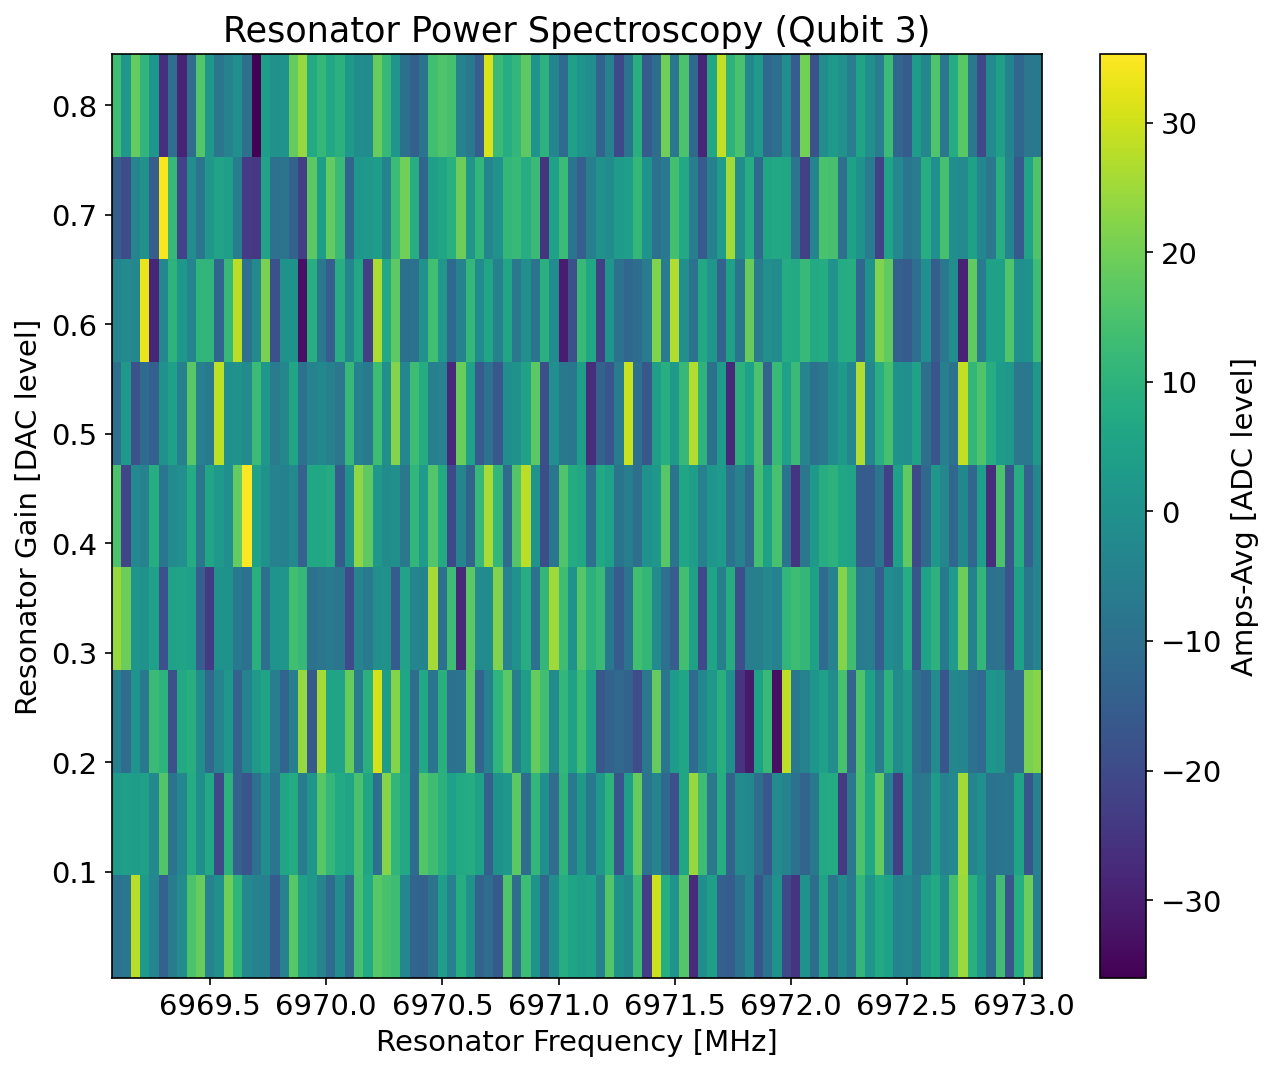

Saving S:\QRAM\qram_4QR2\data\data_241025\00000_power_sweep_resonator_spectroscopy_qubit3.h5


In [67]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec.cfg.expt.qTest)
rpowspec.analyze(fit=False, lowgain=None, highgain=None)
rpowspec.display(fit=False) #, select=[0.3, 0.4, 0.5, 0.6, 0.7])  

rpowspec.save_data() 

In [96]:
data_g = rpowspec.data
amp_g = rpowspec.data['amps']
avgi_g = rpowspec.data['avgi']
avgq_g = rpowspec.data['avgq']

### E state

In [98]:
rpowspec_e = meas.ResonatorPowerSweepSpectroscopyExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"power_sweep_resonator_spectroscopy_qubit{qubit_i}",
    config_file=config_path,
)

rpowspec_e.cfg.expt = dict(
    start_f=rpowspec.cfg.device.readout.frequency[qubit_i]-span_f*0.66, # sweep frequency [MHz]
    step_f=span_f/npts_f, # min step ~1 Hz
    expts_f=npts_f, # Number experiments stepping freq from start
    start_gain=start_gain, # Gain start value
    step_gain=step_gain, # Gain step size
    expts_gain=npts_gain+1, # Number experiments stepping gain from start
    reps=reps, # Number averages per point
    pulse_e=True, # add ge pi pulse before measurement
    pulse_f=False, # add ef pi pulse before measurement
    qTest=qubit_i,
    full_mux_expt = True,
    mask = [0,1,2,3],
    full_mux_ch = 4,
)
rpowspec_e.cfg.device.readout.relax_delay = 400 # Wait time between experiments [us]
rpowspec_e.cfg.device.readout.readout_length = 3
rpowspec_e.cfg.expt.lengths = [rpowspec_e.cfg.device.readout.readout_length]*4

print(rpowspec_e.cfg)

rpowspec_e.go(analyze=False, display=False, progress=True, save=False)

{'device': {'readout': {'trig_offset': 145, 'lo_sideband': [1, 1, 1, 1], 'frequency': [308.97472824556644, -705.0383333999998, 1201.2882333333337, 470.05089277000025], 'gain': [0.04, 0.03, 0.18, 0.035], 'readout_length': 3, 'frequency_ef': [-392.9315036040767, 5794.925333329999, 499.41074988962544, -231.40888647944814], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': 400}, 'qubit': {'f_ge': [4111.128316516939, 4105.867592682015, 4110.994688934281, 4110.579369837695, 3443.482349236793, 3448.8244761496476, 3447.706823169816, 3447.5052085761054, 4762.743580751455, 4761.745710010409, 4762.873962226965, 4762.370786469688, 4380.292461267258, 4379.535103914169, 4380.328267473819, 4380.978717756275], 'f_ef': [3885.0150973325517, 0.0, 0.0, 0.0, 0.0, 3348.490547076936, 0.0, 0.0, 4571.9056482340775, 4570.996526541673, 4572.845483074933, 0.0, 4209.8719428597715, 4205.61697813965, 0.0, 4208.228379127735], 'f_EgGf': [2686.53594683, 0, 2017.3, 2414.92850999], 'f_EgGf_Q': [0, 0, 5883.653411

  0%|          | 0/7 [00:00<?, ?it/s]

qubit 1


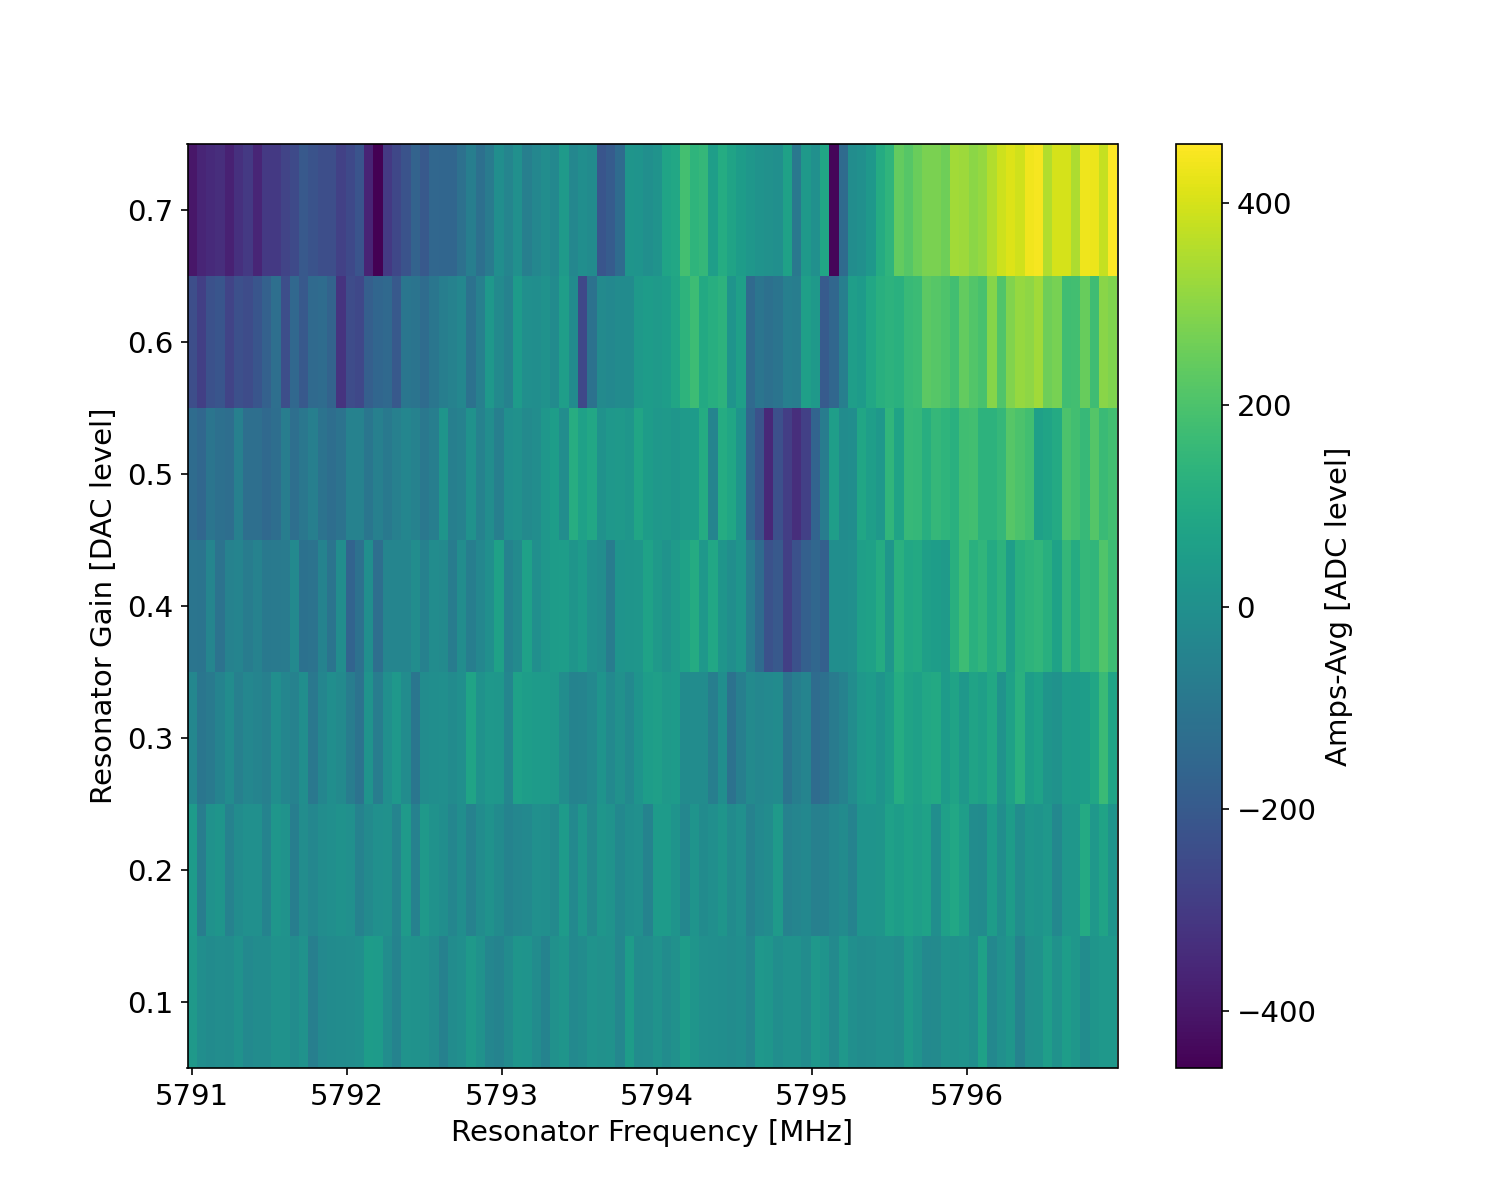

plotting at gain 0.3 index 2
plotting at gain 0.4 index 3
plotting at gain 0.5 index 4
plotting at gain 0.6 index 5
plotting at gain 0.7 index 6
Saving S:\QRAM\qram_4QR2\data\data_240617\00005_power_sweep_resonator_spectroscopy_qubit1.h5


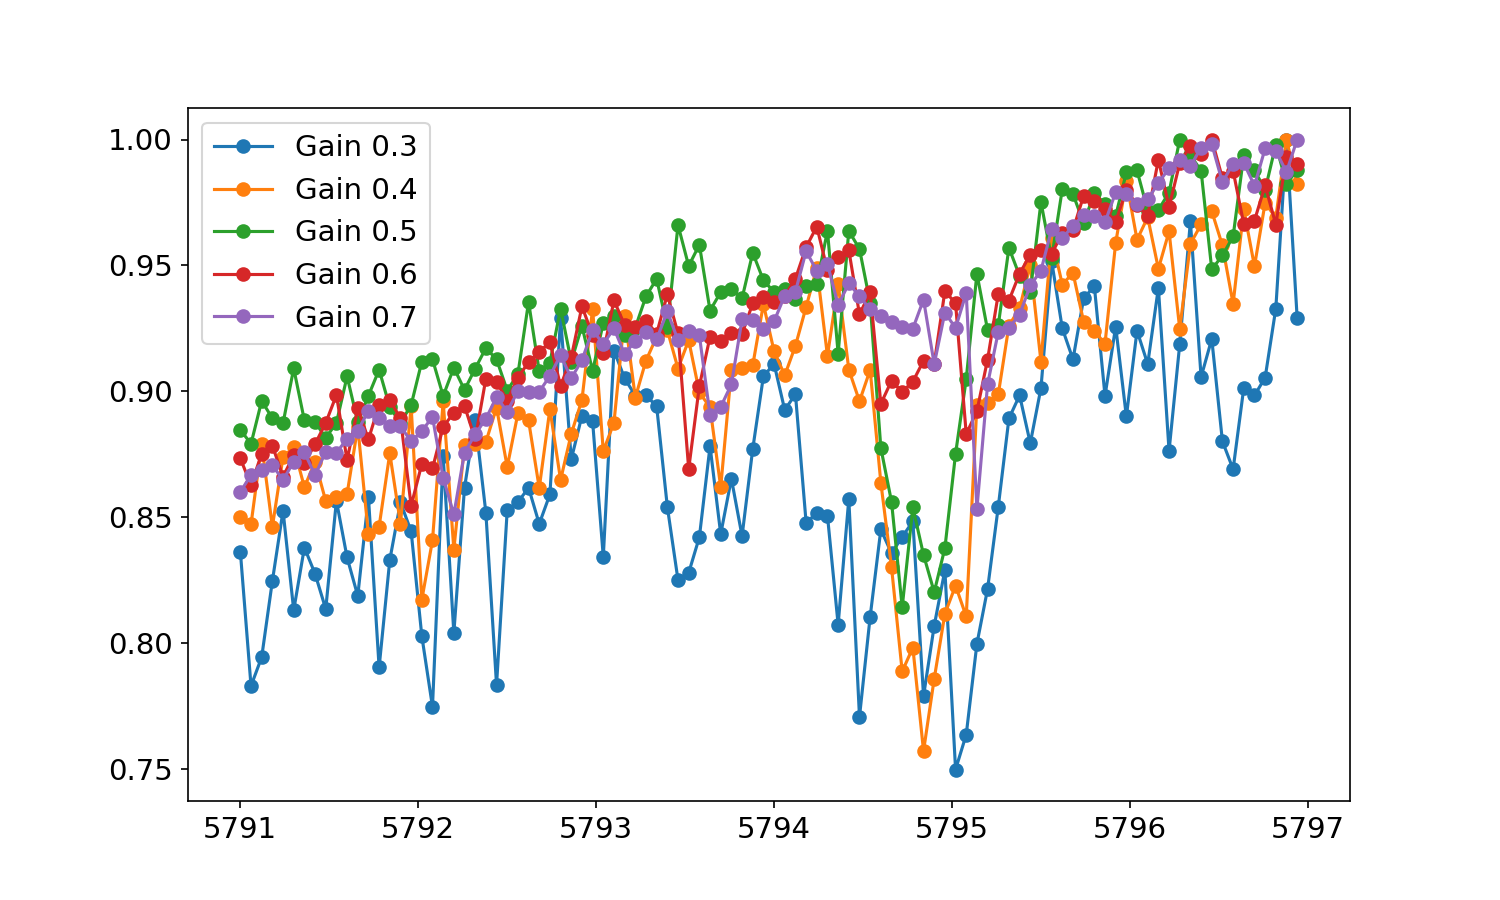

In [99]:
# # TESTING
# rpowspec = meas.ResonatorPowerSweepSpectroscopyExperiment(config_file=config_path)
# temp_data, attrs = prev_data(expt_path, '00000_power_sweep_resonator_spectroscopy_qubit1.h5')
# rpowspec.display(data=temp_data, fit=False)

print('qubit', rpowspec_e.cfg.expt.qTest)
rpowspec_e.analyze(fit=False, lowgain=None, highgain=None)
rpowspec_e.display(fit=False, select=[0.3, 0.4, 0.5, 0.6, 0.7])

rpowspec_e.save_data()

In [100]:
data_e = rpowspec_e.data
amp_e = rpowspec_e.data['amps']

avgi_e = rpowspec_e.data['avgi']
avgq_e = rpowspec_e.data['avgq']

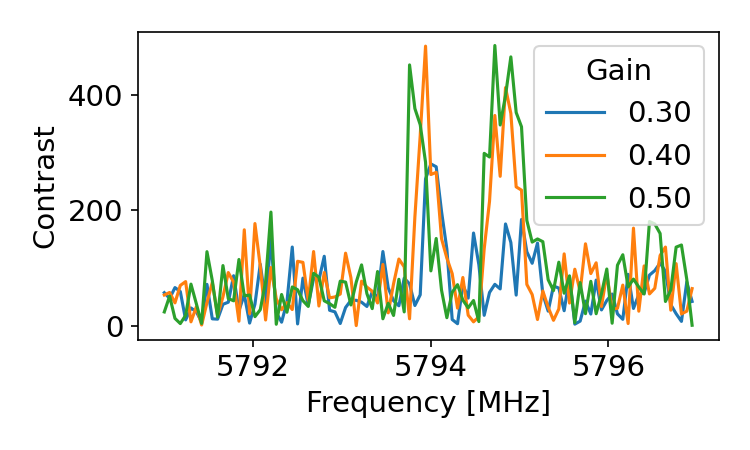

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
contrast = np.abs(amp_e - amp_g)
# contrast = np.sqrt((avgi_g - avgi_e)**2 + (avgq_g - avgq_e)**2)

gain_plot = np.array([0.3, 0.4, 0.5])
idx_plot = np.array([np.argmin(np.abs(data_e['gainpts'] - g)) for g in gain_plot])

# nb_plot = 10
# idx_plot = np.linspace(0, len(data_e['gainpts'])-1, nb_plot).astype(int)



[ax.plot(data_e['xpts'] + yaml_cfg.hw.soc.dacs.readout.mixer_freq, contrast[i], label=f'{data_e["gainpts"][i]:.2f}') for i in (idx_plot)]

ax.set_xlabel('Frequency [MHz]')
ax.set_ylabel('Contrast')

ax.legend(title='Gain')

fig.tight_layout()

# Single shots

In [997]:
use_iq_pulses = True

use_robust_pulses = True # for the qubit pulses

use_full_gen = True

In [998]:
qubit_i = 1

In [1003]:
shot = meas.HistogramExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_qubit{qubit_i}",
    config_file=config_path,
)

if use_full_gen:
    shot.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freqs
    for i in range(4):
        shot.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freqs[i]
        print(f"Qubit {i} frequency: {shot.cfg.device.readout.frequency[i]}")


shot.cfg.expt = dict(
    reps=10000,
    check_e=True,
    check_f=False,
    qTest=qubit_i,
    
)

if use_full_gen:
    shot.cfg.expt.full_mux_expt = True
    shot.cfg.expt.mask = mask
    shot.cfg.expt.full_mux_chs = full_mux_chs
    shot.cfg.device.readout.readout_length = 3
    shot.cfg.expt.lengths = [shot.cfg.device.readout.readout_length]*4    
    shot.cfg.device.readout.gain = [1e-4]*4
    shot.cfg.device.readout.gain[qubit_i] = 0.08
    shot.cfg.expt.plot_IQ = False

    print('mask', mask)
print(shot.cfg.device.readout.gain)
print(shot.cfg.device.readout.frequency)
print(shot.cfg.hw.soc.dacs.readout.mixer_freq)


# shot.cfg.device.readout.frequency[qubit_i]= 5794 - yaml_cfg.hw.soc.dacs.readout.mixer_freq
# shot.cfg.device.readout.gain[qubit_i]= 0.4
# shot.cfg.device.readout.readout_length[qubit_i] = 3
# shot.cfg.expt.lengths = [shot.cfg.device.readout.readout_length]*4
# shot.cfg.device.readout.relax_delay = 500  # Wait time between experiments [us]
# set the gains 

print('qubit', shot.cfg.expt.qTest)
print('readout params', shot.cfg.device.readout)

shot.go(analyze=False, display=False, progress=True, save=False)

Qubit 0 frequency: 310.02499999999964
Qubit 1 frequency: 95.80166666333298
Qubit 2 frequency: 1202.3682333333336
Qubit 3 frequency: 471.10000000000036
mask [0, 1, 2, 3]
[0.0001, 0.08, 0.0001, 0.0001]
[310.02499999999964, 95.80166666333298, 1202.3682333333336, 471.10000000000036]
[6500, 5700, 6500, 6500]
qubit 1
readout params {'trig_offset': 150, 'lo_sideband': [1, 1, 1, 1], 'frequency': [310.02499999999964, 95.80166666333298, 1202.3682333333336, 471.10000000000036], 'gain': [0.0001, 0.08, 0.0001, 0.0001], 'gain_full_mux': [0.35, 0.0001, 0.5, 0.0001], 'readout_length': 3, 'frequency_ef': [-391.80446161500305, 5794.287237348879, 500.35983051204073, -230.41370987900663], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [1004]:
print(shot.cfg)
shot.display(fit=False, amplitude_mode=True)

{'device': {'readout': {'trig_offset': [150, 150, 150, 150], 'lo_sideband': [1, 1, 1, 1], 'frequency': [310.02499999999964, 95.80166666333298, 1202.3682333333336, 471.10000000000036], 'gain': [0.0001, 0.08, 0.0001, 0.0001], 'gain_full_mux': [0.35, 0.0001, 0.5, 0.0001], 'readout_length': [3, 3, 3, 3], 'frequency_ef': [-391.80446161500305, 5794.287237348879, 500.35983051204073, -230.41370987900663], 'readout_length_ef': [10.0, 7.0, 4.0, 8.0], 'relax_delay': [450, 450, 450, 450]}, 'qubit': {'f_ge': [4111.097866562327, 4105.838904759637, 4110.958153299016, 4110.546407850519, 3442.8755721075536, 3448.47856222815, 3447.060317317807, 3446.4929792801067, 4762.761504132457, 4761.823567235975, 4762.909473544484, 4762.369813422167, 4380.698604555338, 4379.604868123916, 4380.717837106693, 4381.248121020163], 'f_ge_robust': [4114.332017402744, 4114.332017402744, 4114.332017402744, 4114.332017402744, 3450.0540893078382, 3450.0540893078382, 3450.0540893078382, 3450.0540893078382, 4763.941, 4763.941, 

## sweeps

In [ ]:
qubit_i = 3

shotopt = meas.SingleShotOptExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"single_shot_opt_qubit{qubit_i}",
    config_file=config_path,
)
# shotopt.cfg = AttrDict(deepcopy(yaml_cfg))

span_f = 1
npts_f = 20
start_f = shotopt.cfg.device.readout.frequency[qubit_i] - span_f/2


# start_gain = 0.005
# stop_gain = 0.035
start_gain = 0.4
stop_gain = 0.95
npts_gain = 10
step_gain = (stop_gain - start_gain) / npts_gain

span_len = 0 # us
npts_len = 1

shotopt.cfg.expt = dict(
    reps=1000,
    qTest=qubit_i,
    start_f=start_f, # [MHz]
    step_f=span_f/npts_f,
    expts_f=npts_f,
    start_gain=start_gain,
    step_gain=step_gain,
    expts_gain=npts_gain + 1,
    start_len=5,
    step_len=span_len/npts_len,
    expts_len=npts_len,
)

shotopt.go(analyze=False, display=False, progress=True, save=False)

  0%|          | 0/20 [00:00<?, ?it/s]

freq: -230.20463576, gain: 0.4, len: 3.0
	fid ge [%]: 14.399999999999999
freq: -230.20463576, gain: 0.455, len: 3.0
	fid ge [%]: 15.8
freq: -230.20463576, gain: 0.51, len: 3.0
	fid ge [%]: 13.600000000000001
freq: -230.20463576, gain: 0.565, len: 3.0
	fid ge [%]: 24.212106053026513
freq: -230.20463576, gain: 0.62, len: 3.0
	fid ge [%]: 15.7
freq: -230.20463576, gain: 0.675, len: 3.0
	fid ge [%]: 17.8
freq: -230.20463576, gain: 0.73, len: 3.0
	fid ge [%]: 19.2
freq: -230.20463576, gain: 0.7849999999999999, len: 3.0
	fid ge [%]: 22.311155577788895
freq: -230.20463576, gain: 0.84, len: 3.0
	fid ge [%]: 27.400000000000002
freq: -230.20463576, gain: 0.895, len: 3.0
	fid ge [%]: 30.0
freq: -230.20463576, gain: 0.95, len: 3.0
	fid ge [%]: 28.8144072036018
freq: -230.15463576, gain: 0.4, len: 3.0
	fid ge [%]: 14.4072036018009
freq: -230.15463576, gain: 0.455, len: 3.0
	fid ge [%]: 17.5
freq: -230.15463576, gain: 0.51, len: 3.0
	fid ge [%]: 15.407703851925964
freq: -230.15463576, gain: 0.565, l

In [1738]:
imax = shotopt.analyze()

print(f'Optimal gain {shotopt.data["gainpts"][imax[1]]},  frequency {shotopt.data["fpts"][imax[0]]} MHz' and f'Optimal readout length {shotopt.data["lenpts"][imax[2]]} us')


# shotopt.display()
fid = shotopt.data['fid']
gain = shotopt.data['gainpts']
fpts = shotopt.data['fpts']
lenpts = shotopt.data['lenpts']

print(fid.shape, gain.shape, fpts.shape, lenpts.shape)


# print 2d plot of the fidelity versus gain and frequency for each readout length
# fid is a 3d array with shape (len(fpts), len(gain), len(lenpts))

for i in range(len(lenpts)):
    fig, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.imshow(fid[:, ::-1, i].T, aspect='auto', extent=[fpts[0], fpts[-1], gain[0], gain[-1]])
    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Gain [ua]')
    ax.set_title(f'Q{qubit_i} Fidelity with readout length {lenpts[i]:.2f} us')
    # add colorbar
    ax.figure.colorbar(ax.images[0], ax=ax)
    fig.tight_layout()



(15, 10, 0)
[-230.20463576 -230.15463576 -230.10463576 -230.05463576 -230.00463576
 -229.95463576 -229.90463576 -229.85463576 -229.80463576 -229.75463576
 -229.70463576 -229.65463576 -229.60463576 -229.55463576 -229.50463576
 -229.45463576 -229.40463576 -229.35463576 -229.30463576 -229.25463576]
[0.4   0.455 0.51  0.565 0.62  0.675 0.73  0.785 0.84  0.895 0.95 ]
[3.]
Max fidelity 86.74337168584292 %
Set params: 
 angle (deg) 102.95588584550549 
 threshold -1064.7262077518308 
 freq [Mhz] -229.45463576 
 gain [dac units] 0.95 
 readout length [us] 3.0
Optimal readout length 3.0 us
(20, 11, 1) (11,) (20,) (1,)


In [ ]:
# plot the slice for the longest readout length


for l in lenpts:
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    [ax.plot(fpts, fid[:, i, np.argmin(np.abs(lenpts - l))], label=f'{gain[i]:.2f}') for i in range(len(gain))]

    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Fidelity')
    ax.legend(title='Gain')
    ax.set_title(f'Readout length {l:.2f} us')
    fig.tight_layout()

# fig, ax = plt.subplots(1, 1, figsize=(7, 5))
# [ax.plot(fpts, fid[:, i, -1], label=f'{gain[i]:.2f}') for i in range(len(gain))]

# ax.set_xlabel('Frequency [MHz]')
# ax.set_ylabel('Fidelity')
# ax.legend(title='Gain')

# fig.tight_layout()

In [ ]:
shotopt.save_data()

## Multi-readout

In [21]:
qubit_i = 0

In [204]:

for qubit_i in [1]:


    multishotopt = meas.MultiReadoutOptExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"multi_readout_opt_qubit{qubit_i}",
        config_file=config_path,
    )

    multishotopt.cfg = AttrDict(deepcopy(yaml_cfg))

    span_f = 1
    npts_f = 20
    start_f = 5794.2 - yaml_cfg.hw.soc.dacs.readout.mixer_freq # [MHz]


    start_gain = 0.005*4
    stop_gain = 0.035*4
    npts_gain = 10
    step_gain = (stop_gain - start_gain) / npts_gain

    start_len = 3
    span_len = 5 # us
    npts_len = 1

    multishotopt.cfg.expt = dict(
        reps=1000,
        qTest=qubit_i,
        start_f=start_f, # [MHz]
        step_f=span_f/npts_f,
        expts_f=npts_f,
        start_gain=start_gain,
        step_gain=step_gain,
        expts_gain=npts_gain,
        start_len=start_len,
        step_len=span_len/npts_len,
        expts_len=npts_len,
        check_e=True,
        check_f=False,
        readout_cool = True, 
        n_init_readout = 1, 
        n_trig = 1,
        init_read_wait_us = 10, 
        avg_trigs = True,
        amplitude_mode = True,
        full_mux_expt = True, 
        )

    if multishotopt.cfg.expt.full_mux_expt:
        multishotopt.cfg.expt.mask = [0,1,2,3]
        multishotopt.cfg.expt.full_mux_ch = 4





    multishotopt.go(analyze=False, display=False, progress=True, save=False)
    multishotopt.save_data()
    multishotopt.display()




TypeError: unsupported operand type(s) for -: 'float' and 'list'

In [1]:
multishotopt.display()

NameError: name 'multishotopt' is not defined

In [ ]:
imax = multishotopt.analyze()

print(f'Optimal gain {multishotopt.data["gainpts"][imax[1]]}')
print(f'Optimal frequency {multishotopt.data["fpts"][imax[0]]} MHz')
print(f'Optimal readout length {multishotopt.data["lenpts"][imax[2]]} us')
print(f'Fidelity {multishotopt.data["fid"][imax[0], imax[1], imax[2]]}')


In [ ]:
imax

gain 0.99 readout length 4.0
qubit 0


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

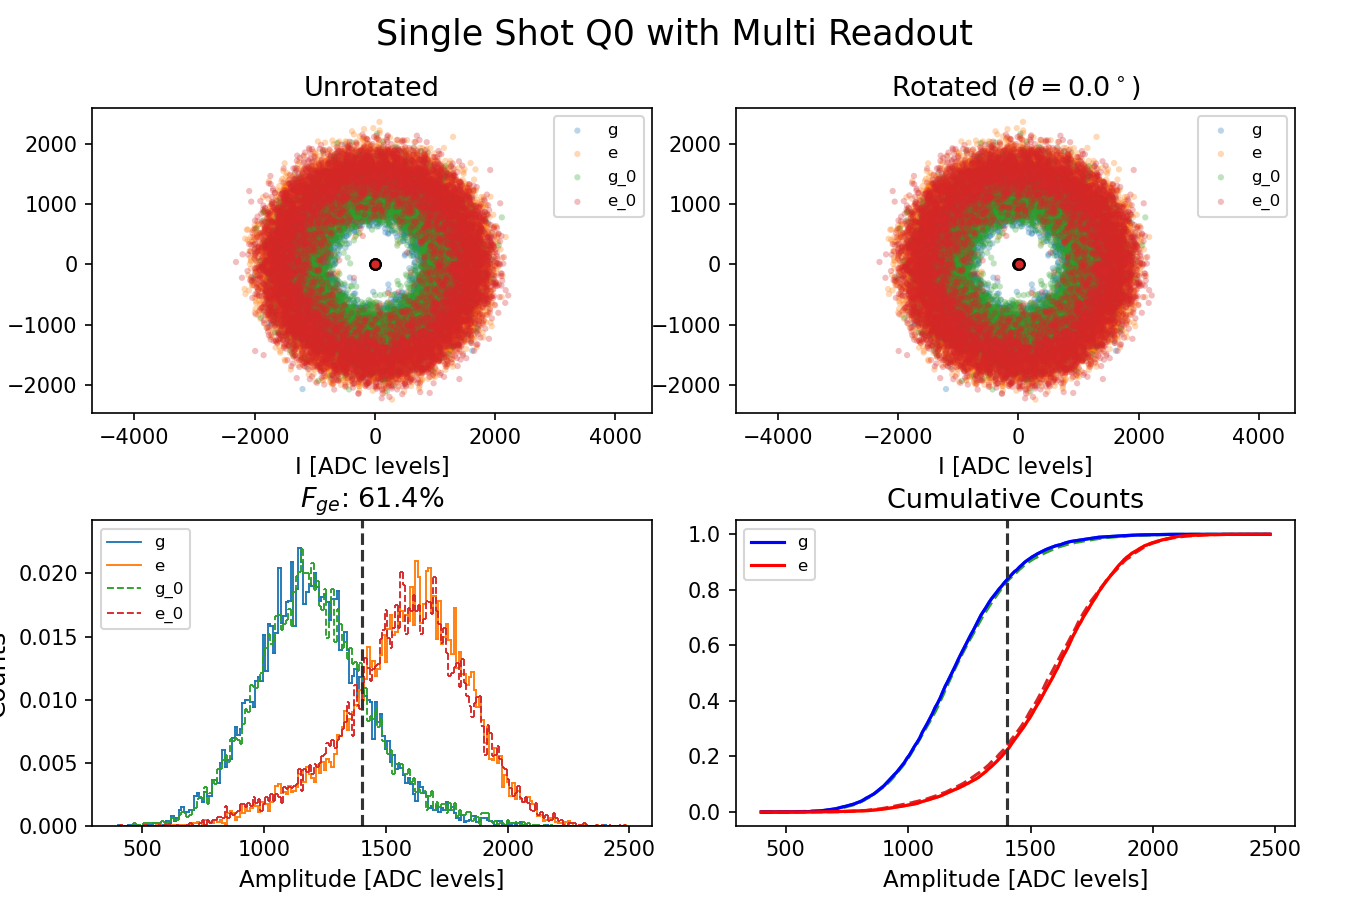

Saving S:\QRAM\qram_4QR2\data\data_240617\00109_multi_readout_qubit0.h5


In [207]:
qubit_i = 0
gain_vec = np.array([0.99])
readout_vec = np.array([4.0])
wait_vec = np.array([10])
n_trig = np.array([1])
# freq =  5794 - yaml_cfg.hw.soc.dacs.readout.mixer_freq
mixer_freq = 6200


for t in n_trig:
    for w in wait_vec:
        for r in readout_vec:
            for g in gain_vec:
                print('gain', g, 'readout length', r)
                
                shot = meas.MultiReadoutExperiment(
                    soccfg=soc,
                    path=expt_path,
                    prefix=f"multi_readout_qubit{qubit_i}",
                    config_file=config_path,
                )
                
                shot.cfg = AttrDict(deepcopy(yaml_cfg))
                for i in range(4):
                    shot.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freq  

                shot.cfg.expt = dict(
                    reps=10000,
                    check_e=True,
                    check_f=False,
                    qTest=qubit_i,
                    readout_cool=True,
                    n_init_readout=1, # number of readout blocks prior to final readout
                    n_trig=t, # extend readout by triggering this many times in a row
                    init_read_wait_us=w, # wait between readout blocks
                    use_gf_readout=False,
                    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
                    full_mux_expt = True, 
  
                )
                if shot.cfg.expt.full_mux_expt:
                    shot.cfg.expt.lengths = [r]*4
                    shot.cfg.device.readout.readout_length = shot.cfg.expt.lengths
                    shot.cfg.expt.mask = [0,1,2,3]
                    shot.cfg.expt.full_mux_ch = 4
                else:
                    for q in range(4):
                        shot.cfg.device.readout.readout_length[q] = r
                shot.cfg.device.readout.frequency[qubit_i]= freq
                shot.cfg.device.readout.gain[qubit_i] = g
                
                if shot.cfg.expt.full_mux_expt:
                    shot.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freq
                
                
                
                
                print('qubit', shot.cfg.expt.qTest)

                try:
                    shot.go(analyze=False, display=False, progress=True, save=False)
                except Exception:
                    print("Pyro traceback:")
                    print("".join(Pyro4.util.getPyroTraceback()))
                    
                shot.analyze(fit=False, check_readouts=[0], post_select=False, verbose=False, amplitude_mode=True, plot=True)
                # shot.display(fit=False, post_select=False, verbose=False, export=False)
                
                shot.save_data()
                

# Optimal pulses

## Pulse definition 

In [ ]:
def filter(t, kappa_ext, kappa_int, chi, func, kerr=0, **kwargs):
    """
    Find the drive function to get a resonator response of func,
    given that the response function occurs when the resonator has intrinsic frequency
    that is chi away from the drive.
    """
    # _f1 = (kappa/2 + 1j*chi)*func(t, **kwargs)
    _f1 = ((kappa_ext + kappa_int)/2 + 1j*chi)*func(t, **kwargs)
    _f2 = (func(t + 1e-7, **kwargs) - func(t - 1e-7, **kwargs))/(2e-7)
    
    a_in = -np.sqrt(2/kappa_ext)*(_f1 + _f2)
    if kerr != 0:
        _f1 =  ((kappa_ext + kappa_int)/2 +
                1j*(chi + 4*kerr*np.abs(a_in)**2))*func(t, **kwargs)
        a_in = -np.sqrt(2/kappa_ext)*(_f1 + _f2)
    return a_in

def sin_func(t, **kwargs):
    # look for Tp in kwargs
    Tp = kwargs['Tp']
    # zero if t < 0 or t > Tp else np.sin(np.pi*t/Tp)**2
    return np.where((t < 0) | (t > Tp), 0, np.sin(np.pi*t/Tp)**4)

def flat_top(t, **kwargs):
    # look for Tp in kwargs
    Tp = kwargs['Tp']
    t_rise = kwargs['t_rise']
    # zero if t < 0 or t > Tp else 1
    rise = np.where((t > 0) & (t < t_rise), np.sin(np.pi*t/t_rise/2)**4, 0)
    flat = np.where((t >= t_rise) & (t <= Tp - t_rise), 1, 0)
    fall = np.where(t > Tp - t_rise, np.sin(np.pi*(Tp-t)/t_rise/2)**4, 0)

    return np.where((t > 0) & (t < Tp), rise + flat + fall, 0)

def cavity_response(t, kappa, chi, drive, **kwargs):
    integrand = lambda t: (np.sqrt(kappa) - kappa/2)**2 + chi**2 * drive(t, **kwargs)**2
    return np.exp(-t/kappa)*np.array([sp.integrate.quad(integrand, 0, t_i)[0] for t_i in t])

def steady_state_cavity_response(kappa, chi):
    return kappa / ((kappa/2)**2 + chi**2)
    

In [348]:
chi = np.array([-0.9902428256070266,-0.7251655629142988,-0.9816037042954804, -0.8046357615893953])*2*np.pi
# kappa_ext = np.array([0.3128611104008721, 0.16343094600616365,0.2477101298487874, 0.17656867403487492])*2*np.pi
kappa_ext = np.array([0.3128611104008721, 0.15,0.2477101298487874, 0.17656867403487492])*2*np.pi
kappa_int = np.array([9.754055730881005e-06, 6.060900466172655e-06, 0.05266887230520246,0.022774970783437157])*2*np.pi
t_flat = 3.0
t_rise = 0.5
Tp = t_flat + 2*t_rise
t_step = 1e-6
t = np.linspace(0, Tp, int(Tp/t_step))

kerr_sweep_Hz = np.linspace(-200, 200, 20)
# kerr_sweep_Hz = np.linspace(-200, 200, 3)
print('kerr sweep', kerr_sweep_Hz)

kerr sweep [-200.         -178.94736842 -157.89473684 -136.84210526 -115.78947368
  -94.73684211  -73.68421053  -52.63157895  -31.57894737  -10.52631579
   10.52631579   31.57894737   52.63157895   73.68421053   94.73684211
  115.78947368  136.84210526  157.89473684  178.94736842  200.        ]


In [339]:
use_chi_shifted_res_freq = False
use_first_filter = False
use_sine_trial = True

use_iq_pulses = True
use_robust_pulses = True # for the qubit pulses
use_full_gen = False

if use_sine_trial: trial_func = sin_func
else: trial_func = flat_top

In [340]:
good_qubit_gains_sine = [1e-4, 0.3, 1e-4, 0.08]
good_qubit_gains_flat_top = [1e-4, 0.6, 1e-4, 1e-4]

In [341]:
qubit_i = 1

In [ ]:
kerr_Hz = -50

filter_params = dict(Tp=Tp, t_rise=t_rise, kerr=kerr_Hz*1e-6*2*np.pi)
if use_chi_shifted_res_freq: sign = -1
else: sign = 1
fs = [filter(t, kappa_ext[q], kappa_int[q], 0, trial_func, **filter_params) for q in range(4)]# control for the readout with qubit in g
f2s = [filter(t, kappa_ext[q], kappa_int[q], chi[q]*sign, lambda tt, **kwargs: filter(tt, kappa_ext[q], kappa_int[q], 0, trial_func, **kwargs), **filter_params) for q in range(4)]# control for the readout with qubit in e also

fs = np.array(fs)
f2s = np.array(f2s)

if use_first_filter:
    I_values = np.real(fs)
    Q_values = np.imag(fs)
else:
    I_values = np.real(f2s)
    Q_values = np.imag(f2s)

In [347]:
qubit_i = 1
f = fs[qubit_i]
f2 = f2s[qubit_i]
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 9))

plt.suptitle(f"Qubit {qubit_i}")
ax[0].plot(t, np.abs(trial_func(t, Tp=Tp, t_rise=t_rise))**2, label='target')
ax[0].set_title('Target Cavity Photon Number')

ax[1].plot(t, np.real(f), label='Re')
ax[1].plot(t, np.imag(f), label='Im')
ax[1].axhline(steady_state_cavity_response(kappa_ext[qubit_i], 0), color='r', linestyle='--', label='steady state drive')
ax[1].legend()
ax[1].set_title('1st filtering')

ax[2].plot(t, np.real(f2), label='Re')
ax[2].plot(t, np.imag(f2), label='Im')
ax[2].legend()
ax[2].set_xlabel('t [us]')
ax[2].set_title('2nd filtering')
plt.tight_layout()
plt.show()

In [ ]:
drive = flat_top(t, Tp=Tp, t_rise=t_rise)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 8))

ax[0].plot(t, drive)
ax[0].set_title('Drive')

ax[1].plot(t, cavity_response(t, kappa_ext[qubit_i], chi[qubit_i], flat_top, Tp=Tp, t_rise=t_rise))
ax[1].set_title('Cavity Response')
ax[1].set_xlabel('t [us]')
plt.show()

In [ ]:
use_iq_pulses = False
use_full_gen = True

## Multi readout single shot

In [1897]:
qubit_i = 1

In [144]:
use_iq_pulses = True
use_robust_pulses = True # for the qubit pulses

use_full_gen = True

In [243]:
shot = meas.MultiReadoutExperiment(
                    soccfg=soc,
                    path=expt_path,
                    prefix=f"multi_readout_qubit{qubit_i}",
                    config_file=config_path,
                )
                
if use_full_gen:
    shot.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freqs
    for i in range(4):
        shot.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freqs[i] 
        print(f"Qubit {i} frequency: {shot.cfg.device.readout.frequency[i]}")

shot.cfg.expt = dict(
    reps=8000,
    check_e=True,
    check_f=False,
    qTest=qubit_i,

    readout_cool=True,
    n_init_readout=1, # number of readout blocks prior to final readout
    n_trig=1, # extend readout by triggering this many times in a row
    init_read_wait_us=3, # wait between readout blocks
    use_gf_readout=False,
    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
    full_mux_expt=use_full_gen, 

)
if shot.cfg.expt.full_mux_expt:
    shot.cfg.device.readout.readout_length = t[-1]
    shot.cfg.expt.mask = mask
    shot.cfg.expt.full_mux_chs = full_mux_chs
    if not use_iq_pulses:
        # shot.cfg.expt.lengths = [t[-1]]*4
        shot.cfg.device.readout.readout_length = 3
        shot.cfg.expt.lengths = [shot.cfg.device.readout.readout_length]*4    
        shot.cfg.device.readout.gain = [1e-4]*4
        shot.cfg.device.readout.gain[qubit_i] = 0.05
    else:
        # shot.cfg.device.readout.gain = shot.cfg.device.readout.gain_full_mux
        shot.cfg.device.readout.gain = [1e-4]*4
        shot.cfg.expt.pulse_I_shapes = I_values
        shot.cfg.expt.pulse_Q_shapes = Q_values
        shot.cfg.expt.times_us = t_us
        shot.cfg.expt.plot_IQ = False

        shot.cfg.device.readout.gain[qubit_i] = 0.5
        
print('qubit', shot.cfg.expt.qTest)
print(shot.cfg.device.readout.gain)
print(shot.cfg.device.readout.frequency)
print(shot.cfg.hw.soc.dacs.readout.mixer_freq)

try:
    shot.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

Qubit 0 frequency: 309.0347571700004
Qubit 1 frequency: 0.0
Qubit 2 frequency: 1201.3866296300002
Qubit 3 frequency: 470.2953642399998
qubit 1
[0.0001, 0.5, 0.0001, 0.0001]
[309.0347571700004, 0.0, 1201.3866296300002, 470.2953642399998]
[6500, 5795.0365011, 6500, 6500]


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/8000 [00:00<?, ?it/s]

In [244]:
shot.analyze(fit=False, check_readouts=[0, 1], post_select=False, verbose=False, amplitude_mode=True, plot=True)
# shot.display(fit=False, post_select=False, verbose=False, export=False)

3
[[0.46558794849356167], [351.7746017416198], 0.0]


{'Ig_baseline': array([[[ 177.86248983,   81.46948739, -197.9007323 , ...,
           139.8445891 ,  -59.55655004,  159.15947925]],
 
        [[ 151.69406021,  182.86086249,   65.77624085, ...,
           197.02196908,  679.66639544,  327.34499593]],
 
        [[ -78.02441009,  218.33848657,  176.65337673, ...,
           213.29373474,  -48.75264443,  -24.06834825]],
 
        [[-119.07729862,  316.27583401,  -17.05044752, ...,
            35.75264443,  -34.46297803,   75.52074858]]]),
 'Qg_baseline': array([[[  97.36208299,  -94.817738  ,  -28.47681041, ...,
          -226.3807974 ,   67.09845403,  128.99267697]],
 
        [[-232.99755899, -664.45728234, -419.20260374, ...,
          -486.35069162, -418.06753458, -536.00162734]],
 
        [[ 155.08218063,   36.26118796,   83.82994304, ...,
            27.9007323 ,  -67.73962571,    5.51586656]],
 
        [[ 238.33848657,  -16.95036615, -145.65825875, ...,
            70.71358828, -207.70138324,   46.01627339]]]),
 'Ie_baseline': ar

In [ ]:
shot.save_data()

## Pi Minus Pi to calibrate photon number after readout reset

In [1909]:
use_iq_pulses = False

use_robust_pulses = True # for the qubit pulses

use_full_gen = False

In [1910]:
qubit_i = 1

In [1911]:
# I_values = np.ones((4, len(t)))
# Q_values = np.zeros((4, len(t)))
# I_values = np.real(f2s)
# Q_values = np.imag(f2s)
t_us = t

piminuspi = meas.PreSelectionPiMinusPiExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"PreSelectionPiMinusPiExpt{qubit_i}",
    config_file=config_path,
)

span_t = 2 # us
npts_t = 20
# npts_t = 5

if use_full_gen:
    piminuspi.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freq
    for i in range(4):
        piminuspi.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freq

piminuspi.cfg.expt = dict(
    start_N=0, # number gate repetitions
    step_N=1,
    expts_N=10,
    start_t=0,
    step_t=span_t/npts_t,
    expts_t=npts_t+1,
    reps=2000,
    loops=1,
    # pulse_type='gauss',
    pulse_type='robust',

    checkEF=False,
    qTest=qubit_i,
    qZZ=None,

    test_pi_half=True,

    # post_process=None,
    post_process='threshold',
    singleshot_reps=15000,

    readout_cool=True,
    n_init_readout=1, # number of readout blocks prior to final readout
    n_trig=1, # extend readout by triggering this many times in a row
    avg_trigs=True, # whether to combine data from trigger stacks into 1 averaged histogram
    use_gf_readout=False,

    full_mux_expt=use_full_gen,

    use_robust_pulses=use_robust_pulses,
)

if use_full_gen:
    piminuspi.cfg.device.readout.readout_length = t[-1]
    piminuspi.cfg.expt.mask = mask
    piminuspi.cfg.expt.full_mux_chs = full_mux_chs
    if not use_iq_pulses:
        piminuspi.cfg.device.readout.gain = [0.0]*4
        piminuspi.cfg.expt.lengths = [t[-1]]*4
        piminuspi.cfg.device.readout.gain[qubit_i] = 0.025
    else:
        # piminuspi.cfg.device.readout.gain = piminuspi.cfg.device.readout.gain_full_mux
        piminuspi.cfg.device.readout.gain = [1e-4]*4
        piminuspi.cfg.expt.pulse_I_shapes = I_values
        piminuspi.cfg.expt.pulse_Q_shapes = Q_values
        piminuspi.cfg.expt.times_us = t_us
        piminuspi.cfg.expt.plot_IQ = False
        piminuspi.cfg.device.readout.gain[qubit_i] = 0.25

print('qubit', piminuspi.cfg.expt.qTest)
print(piminuspi.cfg.device.readout.gain)
print(piminuspi.cfg.device.readout.frequency)
print(piminuspi.cfg.hw.soc.dacs.readout.mixer_freq)


# print(piminuspi.cfg)
try:
    piminuspi.acquire(progress=True, debug=True)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

qubit 1
[0.3, 0.06, 0.85, 0.75]
[-390.96524283, 5795.0365011, 501.38662963, -229.70463576]
[7200, 0, 7200, 7200]


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)
ge fidelity (%): 60.16000000000001 	 angle (deg): 119.11288597002947 	 threshold ge: -1267.4447746327664
thresholds=[0, -1267.4447746327664, 0, 0],
angles=[0, 119.11288597002947, 0, 0],
ge_avgs=[array([0., 0., 0., 0.]), [-583.9212564236112, 1974.0846768229167, -758.9208698784722, 1659.8387619791667], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[12595.0, 2405.0], [3592.0, 11408.0]]


  0%|          | 0/10 [00:00<?, ?it/s]

In [1913]:
# # TESTING
# temp_data, attrs = prev_data('S:\QRAM\qram_4QR2\data\data_241025\\00002_PreSelectionPiMinusPiExpt0.h5')
# piminuspi.data =  temp_data
# piminuspi.cfg = AttrDict(attrs['config'])

data = piminuspi.data
piminuspi.analyze(preselect=False, ps_qubits=[qubit_i], ps_adjust=None, amplitude_mode=piminuspi.cfg.expt.full_mux_expt)
piminuspi.display(preselect=False)

[[12595.  2405.]
 [ 3592. 11408.]] [1524.  476.] [[0.87059869 0.12940131]]
[[12595.  2405.]
 [ 3592. 11408.]] [1599.  401.] [[0.93307786 0.06692214]]
[[12595.  2405.]
 [ 3592. 11408.]] [1649.  351.] [[0.97473065 0.02526935]]
[[12595.  2405.]
 [ 3592. 11408.]] [1703.  297.] [[ 1.00000000e+00 -1.68484822e-16]]
[[12595.  2405.]
 [ 3592. 11408.]] [1599.  401.] [[0.93307786 0.06692214]]
[[12595.  2405.]
 [ 3592. 11408.]] [1733.  267.] [[ 1.00000000e+00 -1.15487621e-16]]
[[12595.  2405.]
 [ 3592. 11408.]] [1656.  344.] [[0.98056203 0.01943797]]
[[12595.  2405.]
 [ 3592. 11408.]] [1709.  291.] [[1.00000000e+00 5.55111512e-17]]
[[12595.  2405.]
 [ 3592. 11408.]] [1667.  333.] [[0.98972565 0.01027435]]
[[12595.  2405.]
 [ 3592. 11408.]] [1624.  376.] [[0.95390425 0.04609575]]
[[12595.  2405.]
 [ 3592. 11408.]] [1573.  427.] [[0.91141842 0.08858158]]
[[12595.  2405.]
 [ 3592. 11408.]] [1702.  298.] [[ 1.00000000e+00 -1.52350336e-16]]
[[12595.  2405.]
 [ 3592. 11408.]] [1631.  369.] [[0.95973564 

In [1126]:
piminuspi.save_data()

Saving S:\QRAM\qram_4QR2\data\data_241025\00004_PreSelectionPiMinusPiExpt0.h5


'S:\\QRAM\\qram_4QR2\\data\\data_241025\\00004_PreSelectionPiMinusPiExpt0.h5'

## Readout ringdown

In [307]:
use_iq_pulses = True

use_robust_pulses = True # for the qubit pulses

use_full_gen = False

In [290]:
qubit_i = 1

In [308]:
ringdown = meas.ResonatorRingDownExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"resonator_ringdown_qubit{qubit_i}",
    config_file=config_path,
)

if use_full_gen:
    ringdown.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freqs
    for i in range(4):
        ringdown.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freqs[i]
        print(f"Qubit {i} frequency: {ringdown.cfg.device.readout.frequency[i]}")

span = 10.0 # us
npts = 100
# npts = 10
ringdown.cfg.expt = dict(
    start_time=soc.cycles2us(3), # [MHz]
    step_time=span/npts,
    expts=npts,
    # reps=reps*rounds,
    reps=20000,
    pulse_e=False, # add ge pi pulse prior to measurement
    pulse_f=False, # add ef pi pulse prior to measurement
    qTest=qubit_i,
    qZZ=None,
    full_mux_expt=use_full_gen, 
    len_readout_adc=[2]*4,
)

# ringdown.cfg.device.readout.gain[qubit_i] = 0.3
# ringdown.cfg.device.readout.readout_length[qubit_i] = 3

if ringdown.cfg.expt.full_mux_expt:
    ringdown.cfg.device.readout.readout_length = t[-1]
    ringdown.cfg.expt.mask = mask
    ringdown.cfg.expt.full_mux_chs = full_mux_chs
    # ringdown.cfg.device.readout.trig_offset = 0
    if not use_iq_pulses:
        # ringdown.cfg.expt.lengths = [t[-1]]*4
        ringdown.cfg.device.readout.readout_length = 3
        ringdown.cfg.expt.lengths = [ringdown.cfg.device.readout.readout_length]*4    
        ringdown.cfg.device.readout.gain = [1e-4]*4
        ringdown.cfg.device.readout.gain[qubit_i] = 0.05
    else:
        # ringdown.cfg.device.readout.gain = ringdown.cfg.device.readout.gain_full_mux
        ringdown.cfg.device.readout.gain = [1e-4]*4
        ringdown.cfg.expt.pulse_I_shapes = I_values
        ringdown.cfg.expt.pulse_Q_shapes = Q_values
        ringdown.cfg.expt.times_us = t_us
        ringdown.cfg.expt.plot_IQ = False
        ringdown.cfg.device.readout.gain[qubit_i] = 0.5

ringdown.cfg.device.readout.gain[qubit_i] = 0.01/4
# ringdown.cfg.device.readout.gain = [1e-4]*4
# ringdown.cfg.device.readout.gain[qubit_i] = 0.3

print(ringdown.cfg.device.readout.gain)
print(ringdown.cfg.device.readout.frequency)
print(ringdown.cfg.hw.soc.dacs.readout.mixer_freq)

if not ringdown.cfg.expt.pulse_e: ringdown.cfg.device.readout.relax_delay = 25

try:
    ringdown.go(analyze=False, display=False, progress=True, save=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))

[0.3, 0.0025, 0.85, 0.75]
[-389.975, 5795.761666663333, 502.368233333334, -228.9]
[7200, 0, 7200, 7200]


  0%|          | 0/100 [00:00<?, ?it/s]

[153, 153, 153, 153]
Readout time: 0.006975446428571429 us, Offset time: 0.006975446428571429 us
[196, 196, 196, 196]
Readout time: 0.10697544642857143 us, Offset time: 0.10697544642857143 us
[239, 239, 239, 239]
Readout time: 0.20697544642857144 us, Offset time: 0.20697544642857144 us
[282, 282, 282, 282]
Readout time: 0.3069754464285715 us, Offset time: 0.3069754464285715 us
[325, 325, 325, 325]
Readout time: 0.4069754464285715 us, Offset time: 0.4069754464285715 us
[368, 368, 368, 368]
Readout time: 0.5069754464285714 us, Offset time: 0.5069754464285714 us
[411, 411, 411, 411]
Readout time: 0.6069754464285715 us, Offset time: 0.6069754464285715 us
[454, 454, 454, 454]
Readout time: 0.7069754464285715 us, Offset time: 0.7069754464285715 us
[497, 497, 497, 497]
Readout time: 0.8069754464285714 us, Offset time: 0.8069754464285714 us
[540, 540, 540, 540]
Readout time: 0.9069754464285714 us, Offset time: 0.9069754464285714 us
[583, 583, 583, 583]
Readout time: 1.0069754464285714 us, Offs

In [309]:
# TESTING
# # ringdown = meas.ResonatorRingDownExperiment(config_file=config_path,) 
# temp_data, attrs = prev_data(expt_path, '00001_resonator_spectroscopy_qubit2.h5')
# ringdown.data = temp_data

ringdown.data = ringdown.analyze(fit=True)
# ringdown_fit = ringdown.data['fit']
# if not isinstance(ringdown_fit, (list, np.ndarray)):
#     ringdown.display(fit=False)
#     assert False, 'Fit failed, please manually fix!'
ringdown.display(fit=True)

### Readout ringdown Kerr iteration

In [314]:
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

freqs = np.array(yaml_cfg.device.readout.frequency)
mixer = np.array(yaml_cfg.hw.soc.dacs.readout.mixer_freq)
res_freq = freqs + mixer
print('Resonator frequencies:', res_freq)

Resonator frequencies: [6810.025      5795.76166666 7702.36823333 6971.1       ]


In [315]:
full_mux_chs = [5, 4, 5, 5]
# full_mux_chs = [4]*4
mixer_freqs = [6500, res_freq[1], 6500, 6500]
# mixer_freqs = [6500, 5700, 6500, 6500]
# mixer_freqs = [6500]*4
mask = [0, 1, 2, 3]

print('mixer freqs', mixer_freqs)
wrapped_freqs = res_freq - mixer_freqs
print('orig unmixed freqs', wrapped_freqs)

fs = 2457.6
print(fs/2)
for i_f, f in enumerate(wrapped_freqs):
    if f > fs/2:
        wrapped_freqs[i_f] = fs - f
print('wrapped freqs', wrapped_freqs.tolist())
print('wrapped freqs with mixer', wrapped_freqs + mixer)

# use_full_gen = False
use_full_gen = True

mixer freqs [6500, 5795.761666663333, 6500, 6500]
orig unmixed freqs [ 310.025         0.         1202.36823333  471.1       ]
1228.8
wrapped freqs [310.02499999999964, 0.0, 1202.3682333333336, 471.10000000000036]
wrapped freqs with mixer [7510.025         0.         8402.36823333 7671.1       ]


In [335]:
chi = np.array([-0.9902428256070266,-0.7251655629142988,-0.9816037042954804, -0.8046357615893953])*2*np.pi
# kappa_ext = np.array([0.3128611104008721, 0.16343094600616365,0.2477101298487874, 0.17656867403487492])*2*np.pi
kappa_ext = np.array([0.3128611104008721, 0.15,0.2477101298487874, 0.17656867403487492])*2*np.pi
kappa_int = np.array([9.754055730881005e-06, 6.060900466172655e-06, 0.05266887230520246,0.022774970783437157])*2*np.pi
t_flat = 3.0
t_rise = 0.5
Tp = t_flat + 2*t_rise
t_step = 0.00001
t = np.linspace(0, Tp, int(Tp/t_step))

kerr_sweep_Hz = np.linspace(-200, 200, 20)
# kerr_sweep_Hz = np.linspace(-200, 200, 3)
print('kerr sweep', kerr_sweep_Hz)

kerr sweep [-200.         -178.94736842 -157.89473684 -136.84210526 -115.78947368
  -94.73684211  -73.68421053  -52.63157895  -31.57894737  -10.52631579
   10.52631579   31.57894737   52.63157895   73.68421053   94.73684211
  115.78947368  136.84210526  157.89473684  178.94736842  200.        ]


In [331]:
use_chi_shifted_res_freq = False
use_first_filter = False
use_sine_trial = True

use_iq_pulses = True
use_robust_pulses = True # for the qubit pulses
use_full_gen = False

if use_sine_trial: trial_func = sin_func
else: trial_func = flat_top

In [332]:
good_qubit_gains_sine = [1e-4, 0.3, 1e-4, 0.08]
good_qubit_gains_flat_top = [1e-4, 0.6, 1e-4, 1e-4]

In [333]:
qubit_i = 1

In [ ]:
t_us = t

ringdown_kerr_expt = Experiment(
    path=expt_path,
    prefix=f"ringdown_kerr_sweep_qubit{qubit_i}",
    config_file=config_path,
)
ringdown_kerr_expt.data = dict(times=[], kerr_sweep_Hz=kerr_sweep_Hz, avgi=[], avgq=[], amps=[])

for kerr_Hz in tqdm(kerr_sweep_Hz):
    filter_params = dict(Tp=Tp, t_rise=t_rise, kerr=kerr_Hz*1e-6*2*np.pi)
    if use_chi_shifted_res_freq: sign = -1
    else: sign = 1
    fs = [filter(t, kappa_ext[q], kappa_int[q], 0, trial_func, **filter_params) for q in range(4)]# control for the readout with qubit in g
    f2s = [filter(t, kappa_ext[q], kappa_int[q], chi[q]*sign, lambda tt, **kwargs: filter(tt, kappa_ext[q], kappa_int[q], 0, trial_func, **kwargs), **filter_params) for q in range(4)]# control for the readout with qubit in e also

    fs = np.array(fs)
    f2s = np.array(f2s)

    if use_first_filter:
        I_values = np.real(fs)
        Q_values = np.imag(fs)
    else:
        I_values = np.real(f2s)
        Q_values = np.imag(f2s)

    ringdown = meas.ResonatorRingDownExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"resonator_ringdown_qubit{qubit_i}",
        config_file=config_path,
    )

    if use_full_gen:
        ringdown.cfg.hw.soc.dacs.readout.mixer_freq = mixer_freqs
        for i in range(4):
            ringdown.cfg.device.readout.frequency[i] = res_freq[i] - mixer_freqs[i]
            if use_chi_shifted_res_freq: ringdown.cfg.device.readout.frequency[i] += chi[i]
            print(f"Qubit {i} frequency: {ringdown.cfg.device.readout.frequency[i]}")

    span = 10.0 # us
    npts = 100
    # npts = 10
    ringdown.cfg.expt = dict(
        start_time=soc.cycles2us(3), # [MHz]
        step_time=span/npts,
        expts=npts,
        # reps=reps*rounds,
        reps=1000,
        pulse_e=False, # add ge pi pulse prior to measurement
        pulse_f=False, # add ef pi pulse prior to measurement
        qTest=qubit_i,
        qZZ=None,
        full_mux_expt=use_full_gen, 
        len_readout_adc=[2]*4,
    )

    # ringdown.cfg.device.readout.gain[qubit_i] = 0.3
    # ringdown.cfg.device.readout.readout_length[qubit_i] = 3

    if ringdown.cfg.expt.full_mux_expt:
        ringdown.cfg.device.readout.readout_length = t[-1]
        ringdown.cfg.expt.mask = mask
        ringdown.cfg.expt.full_mux_chs = full_mux_chs
        # ringdown.cfg.device.readout.trig_offset = 0
        if not use_iq_pulses:
            # ringdown.cfg.expt.lengths = [t[-1]]*4
            ringdown.cfg.device.readout.readout_length = 3
            ringdown.cfg.expt.lengths = [ringdown.cfg.device.readout.readout_length]*4    
            ringdown.cfg.device.readout.gain = [1e-4]*4
            ringdown.cfg.device.readout.gain[qubit_i] = 0.05
        else:
            ringdown.cfg.expt.pulse_I_shapes = I_values
            ringdown.cfg.expt.pulse_Q_shapes = Q_values
            ringdown.cfg.expt.times_us = t_us
            ringdown.cfg.expt.plot_IQ = False
            # ringdown.cfg.device.readout.gain = ringdown.cfg.device.readout.gain_full_mux
            # ringdown.cfg.device.readout.gain = [1e-4]*4
            if use_sine_trial: ringdown.cfg.device.readout.gain = good_qubit_gains_sine
            else: ringdown.cfg.device.readout.gain = good_qubit_gains_flat_top

    # print(ringdown.cfg.device.readout.gain)
    # print(ringdown.cfg.device.readout.frequency)
    # print(ringdown.cfg.hw.soc.dacs.readout.mixer_freq)

    if not ringdown.cfg.expt.pulse_e: ringdown.cfg.device.readout.relax_delay = 25

    try:
        ringdown.go(analyze=False, display=False, progress=False, save=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))

    ringdown_kerr_expt.cfg = ringdown.cfg
    ringdown_kerr_expt.data['times'] = ringdown.data['xpts']
    ringdown_kerr_expt.data['avgi'].append(ringdown.data['avgi'])
    ringdown_kerr_expt.data['avgq'].append(ringdown.data['avgq'])
    ringdown_kerr_expt.data['amps'].append(ringdown.data['amps'])


100%|██████████| 20/20 [03:29<00:00, 10.46s/it]


In [337]:
data = ringdown_kerr_expt.data
inner_sweep = data['times']
outer_sweep = data['kerr_sweep_Hz']

x_sweep = inner_sweep
y_sweep = outer_sweep

plt.figure(figsize=(8, 6))
plt.title(f"Ringdown Q{qubit_i} Kerr Sweep")
plt.pcolormesh(x_sweep, y_sweep, data["amps"], cmap="viridis", shading="auto")
plt.xlabel("Times [us]")
plt.ylabel("Kerr [Hz]")
plt.colorbar(label="Amplitude")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.title(f"Ringdown Q{qubit_i} Kerr Sweep")
for i, kerr in enumerate(outer_sweep):
    plt.plot(inner_sweep, data["amps"][i], label=f"{kerr:.2f} Hz")
plt.xlabel("Times [us]")
plt.ylabel("Amplitude")
# plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 7))
plt.title(f"IQ trajectory Q{qubit_i}")
for i, kerr in enumerate(outer_sweep):
    plt.plot(data["avgi"][i], data["avgq"][i], label=f"{kerr:.2f} Hz")
plt.xlabel("I [ADC units]")
plt.ylabel("Q [ADC units]")
plt.tight_layout()
plt.show()
